# 심장병 예측 경진대회 베이스라인 2

이번 대회는 의료데이터를 바탕으로 해당 환자에게 심장병이 있는지 없는지 판단하는 2진분류 대회입니다.

의료 데이터는 다양하게 존재할 수 있는데요 의료 데이터를 바탕으로 진단을 내리는 것은 현재도 활발하게 연구되고있는 분야중 하나입니다.

이번 대회에서는 환자의 데이터를 바탕으로 심장병 진단을 내리는 모델을 만들어 봅시다.

저번 베이스라인 모델은 기본적은 모델만 사용해 모델을 만들어 보았습니다.

이번 베이스라인 모델은 조금 더 좋은 성능의 모델을 만들기 위해 단계적 회귀라는 기법을 사용해 볼 것입니다.

자 그럼 시작해볼까요?

# 데이터 불러오기 + 살펴보기

먼저 분석하려는 데이터를 작업장으로 가져오는 작업이 필요합니다.

이를 위해서 파이썬 라이브러리 중 하나인 Pandas를 이용합니다.

pandas 라이브러리는 엑셀과 같은 행과 열로 이루어진 테이블(table) 형식의 데이터를 편하게 다루도록 해주는 라이브러리입니다.

데이터 분석에는 반드시 사용된다고 해도 과언이 아닌 라이브러리이니, 시간이 날때마다 공부해둡시다.

# 학습 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# csv 형식으로 된 데이터 파일을 읽어옵니다.
train = pd.read_csv('dataset/train.csv')

train

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1,53,1,2,130,197,1,0,152,0,1.2,0,0,2,1
1,2,52,1,3,152,298,1,1,178,0,1.2,1,0,3,1
2,3,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0
3,4,45,0,0,138,236,0,0,152,1,0.2,1,0,2,1
4,5,35,1,1,122,192,0,1,174,0,0.0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,147,50,1,2,140,233,0,1,163,0,0.6,1,1,3,0
147,148,51,1,2,94,227,0,1,154,1,0.0,2,1,3,1
148,149,69,1,3,160,234,1,0,131,0,0.1,1,1,2,1
149,150,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0


데이터를 살펴보면 조금 특이한 데이터들이 있습니다.

age, chol 과 같은 데이터들은 수치를 나타내는 데이터로 수치형(numerical) 데이터라고 합니다.

반면, sex,cp 와 같은 데이터는 수치가 아닌 종류를 나타내죠. 이러한 데이터를 범주형(categorical) 데이터라고 합니다.
 
이러한 범주형 데이터가 숫자로 표시되어 있다는 것은 데이터가 이미 인코딩이 되어있다고 생각해도 무방합니다. 

# 결측치 확인 
비어있는 데이터가 있을 수 있으니 결측치가 있는지 확인해봅시다!

In [2]:
def check_missing_col(dataframe):
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'총 {missing_values}개의 결측치가 존재합니다.')

    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')

check_missing_col(train)

결측치가 존재하지 않습니다


본 데이터에는 결측치가 없지만 결측치가 있는 데이터에는 결측치들을 처리해줘야 합니다.

결측치가 있는 경우 랜덤한 값으로 결측치를 채우거나 중간값 또는 평균으로 결측치를 채워 넣는 방법 등으로 결측치들을 처리할 수 있습니다!


# 상관계수 분석 & 시각화
데이터를 분석하기 전에 간단한 상관관계 분석으로 데이터의 특성을 살펴봅시다.

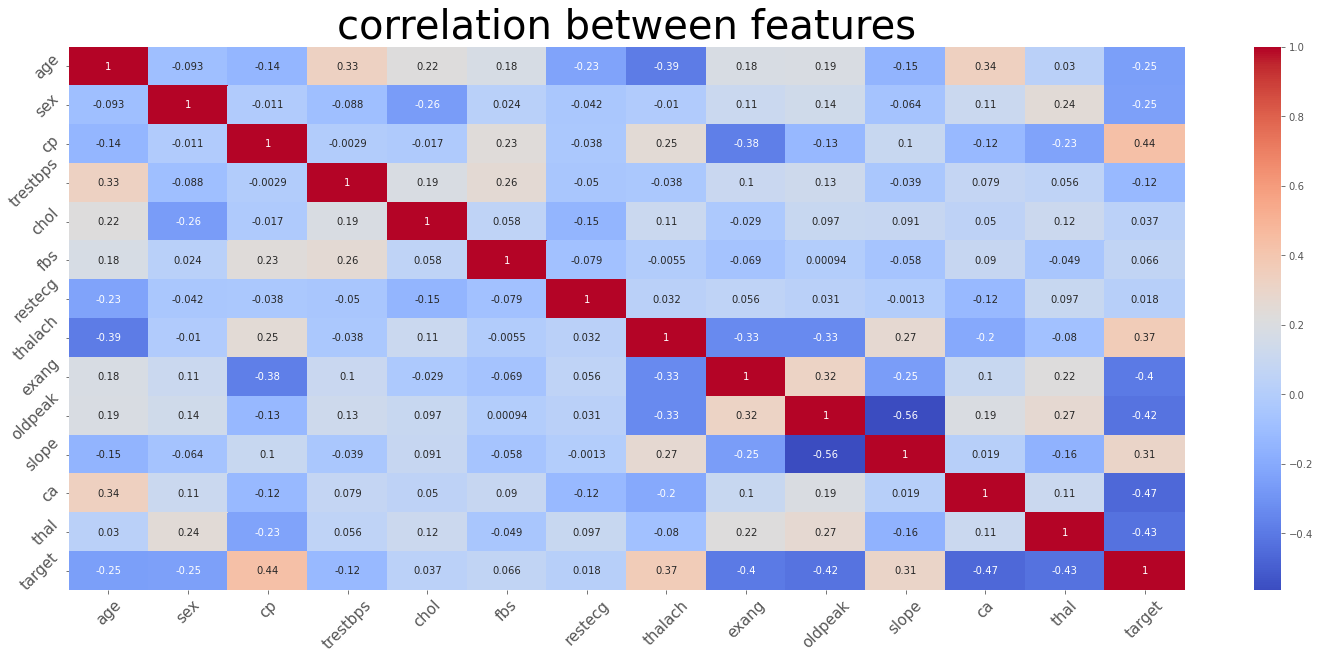

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(25,10))

heat_table = train.drop(['id'], axis=1).corr()
heatmap_ax = sns.heatmap(heat_table, annot=True,cmap='coolwarm')

heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15, rotation=45)

plt.title('correlation between features', fontsize=40)
plt.show()

# 단계적 회귀 (Stepwise Regression)

심장 질환을 예측하기 위해서는 데이터의 여러가지 feature 들을 분석해야 합니다.

그러나 모든 feature 들이 모두 target 에 유의미한 영향을 끼치는 것은 아닙니다. 

어떤 feature 들은 target 에 더 큰 영향을 미치기도 하며 어떤 feature 들은 상대적으로 적은 영향을 끼치기도 합니다. 

단계적 회귀는 데이터의 이러한 특성을 이용합니다. target 에의 영향력이 약한 feature 부터 단계적으로 제외해 나가며 가장 영향력이 큰 feature들만을 분석에 사용하는 기법입니다.

이번 베이스라인 코드에서는 feature 가 target 에 행사하는 영향력을 상관관계로 정의하겠습니다. 

In [4]:
# target과 다른 feature들의 상관계수는 아래와 같습니다.
corr_score = abs(heat_table.target[:-1])

# 상관계수 절대값을 기준으로 내림차순으로 정렬합니다.
corr_score.sort_values()

restecg     0.017528
chol        0.036991
fbs         0.065821
trestbps    0.122850
sex         0.246289
age         0.247806
slope       0.305994
thalach     0.365249
exang       0.396145
oldpeak     0.421514
thal        0.428530
cp          0.436273
ca          0.466289
Name: target, dtype: float64

확인해보니 restecg -> chol -> fbs -> trestbps -> age -> sex -> slope 순이네요!

따라서 restecg 시작으로 feature들을 제거하며 성능 변화를 확인해보겠습니다.

In [5]:
# 성능 변화 평가를 위해 data 나누기
X = train.iloc[:, 1:-1] 
Y = train.iloc[:, -1] 

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.5, shuffle=True, random_state=34)

In [6]:
# 성능 출력 함수
from sklearn.metrics import f1_score

def print_score(predicted, y):
    accuracy = sum(predicted == y) / len(y)*100
    f1 = f1_score(y, predicted)*100
    print(f'accuracy: {accuracy:.2f}%') # 정확도 출력
    print(f'f1_score : {f1:.2f}%') # f1 score 출력
    return accuracy, f1


check_acc = []
check_f1 = []

## 1 단계: feature 삭제 없이 검증

첫 번째 모델로는 모든 feature 들을 사용해 학습한 모델을 만들어 보겠습니다. 

이후 상관관계가 낮은 feature 부터 하나씩 feature 들을 삭제해보며 모델을 만들고 어떤 모델이 가장 성능이 좋은지 살펴봅시다.

In [7]:
from sklearn.linear_model import LogisticRegression
#1단계 train 데이터 준비
step_1_train_x = x_train.copy()

#1단계 train
LR_step_1_model = LogisticRegression()
LR_step_1_model.fit(step_1_train_x, y_train)
#1단계 validation 데이터 준비
step_1_val_x = x_val.copy()

#1단계 validaion
LR_step_1_preds = LR_step_1_model.predict(step_1_val_x)
acc, f1 = print_score(LR_step_1_preds, y_val)

check_acc.append(acc)
check_f1.append(f1)

accuracy: 80.26%
f1_score : 83.87%


## 2단계: ["restecg"] feature 삭제

In [8]:
#2단계 train 데이터 준비
step_2_train_x = x_train.drop("restecg",axis=1)

#2단계 train
LR_step_2_model= LogisticRegression()
LR_step_2_model.fit(step_2_train_x, y_train)

#2단계 validation 데이터 준비
step_2_val_x = x_val.drop("restecg", axis=1)

#2단계 validation
LR_step_2_preds = LR_step_2_model.predict(step_2_val_x)
acc, f1 = print_score(LR_step_2_preds, y_val)

check_acc.append(acc)
check_f1.append(f1)

accuracy: 81.58%
f1_score : 85.11%


## 3단계: ["restecg" , "thalach"] feature 삭제

In [9]:
#3단계 train 데이터 준비
step_3_train_x = x_train.drop(["restecg","chol"],axis=1)

#3단계 train 
LR_step_3_model= LogisticRegression()
LR_step_3_model.fit(step_3_train_x, y_train)

#3단계 validation 데이터 준비
step_3_val_x = x_val.drop(["restecg","chol"],axis=1)

#3단계 validation
LR_step_3_preds = LR_step_3_model.predict(step_3_val_x)
acc, f1 = print_score(LR_step_3_preds, y_val)

check_acc.append(acc)
check_f1.append(f1)


accuracy: 80.26%
f1_score : 84.21%


## 4단계: ["restecg","chol","fbs"] feature 삭제

In [10]:
#4단계 train 데이터 준비
step_4_train_x = x_train.drop(["restecg","chol","fbs"],axis=1)

#4단계 train
LR_step_4_model= LogisticRegression()
LR_step_4_model.fit(step_4_train_x,y_train)

#4단계 validaion 데이터 준비
step_4_val_x = x_val.drop(["restecg","chol","fbs"],axis=1)

#4단계 validation
LR_step_4_preds = LR_step_4_model.predict(step_4_val_x)
acc, f1 = print_score(LR_step_4_preds,y_val)

check_acc.append(acc)
check_f1.append(f1)

accuracy: 81.58%
f1_score : 85.11%


## 5단계: ["restecg","chol","fbs","trestbps"] feature 삭제 

In [11]:
#5단계 trian 데이터 준비
step_5_train_x = x_train.drop(["restecg","chol","fbs","trestbps"],axis=1)

#5단계 train
LR_step_5_model= LogisticRegression()
LR_step_5_model.fit(step_5_train_x,y_train)

#5단계 validation 데이터 준비
step_5_val_x = x_val.drop(["restecg","chol","fbs","trestbps"],axis=1)

#5단계 validation
LR_step_5_preds = LR_step_5_model.predict(step_5_val_x)
acc, f1 = print_score(LR_step_5_preds,y_val)

check_acc.append(acc)
check_f1.append(f1)

accuracy: 85.53%
f1_score : 87.64%


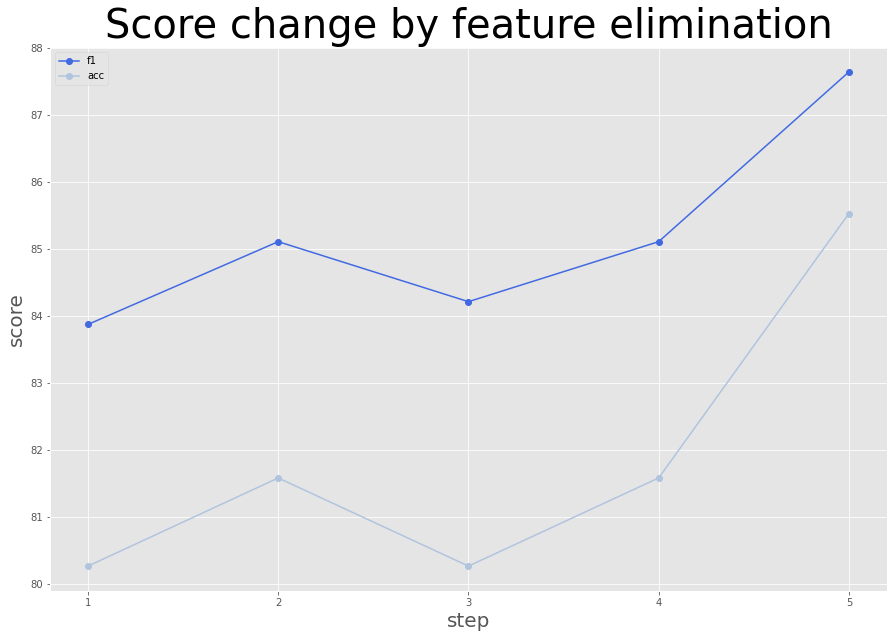

In [12]:
#5개의 모델들의 성능 비교해보기
step = [1,2,3,4,5]

#plt.bar(step,acc,label="acc")
plt.figure(figsize=(15,10))
plt.plot(step, check_f1, 'bo-', label="f1", color = 'royalblue')
plt.plot(step, check_acc, 'bo-', label='acc', color='lightsteelblue')

plt.title("Score change by feature elimination", size=40)
plt.xlabel("step", size=20)
plt.ylabel("score", size=20)
plt.xticks(step)
plt.legend()
plt.show()

보아하니 feature들을 제거할수록 성능이 높게 나오네요!

# best model train 
단계적 회귀분석을 통해 best model 을 결정했으니 submission 제출을 위해 전체 training set으로 다시 학습합니다.

In [13]:
best_model_train_x = X.drop(["restecg","chol","fbs","trestbps"],axis=1)

best_model = LogisticRegression()
best_model.fit(best_model_train_x,Y)

LogisticRegression()

# 예측 값 생성 및 제출하기

학습한 모델을 사용하여 예측값을 생성하고 대회에 제출해보겠습니다.

In [14]:
#test data 준비
test = pd.read_csv("dataset/test.csv")

best_model_test = test.drop(["id","restecg","chol","fbs","trestbps"],axis=1)

# 값을 예측합니다.
prediction = best_model.predict(best_model_test)

이제 이 예측 결과를 submission.csv 파일로 만들어서 대회 페이지에 제출해보도록 합시다.

제출한 뒤 리더보드를 통해 결과를 확인합시다.

In [15]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv('dataset/sample_submission.csv')
submission['target'] = prediction
submission

,id,target
0,1,0
1,2,1
2,3,1
3,4,0
4,5,1
...,...,...
147,148,0
148,149,0
149,150,0
150,151,1


In [16]:
# submission을 csv 파일로 저장합니다.
# index=False란 추가적인 id를 부여할 필요가 없다는 뜻입니다. 
# 정확한 채점을 위해 꼭 index=False를 넣어주세요.
submission.to_csv("submission.csv", index=False)

이렇게 생성된 submission.csv 파일을 데이콘 대회 페이지에 업로드 & 제출하여 결과를 확인해보세요!

문제를 해결하기 위한 여러분의 방법을 코드 공유 게시판에 공유해주세요

좋아요와 댓글을 합산하여 가장 높은 점수를 얻으신 분께 데이콘 후드가 제공됩니다!